# Практическая часть ДЗ 2

# Задача 1. Использование ALS для построения рекомендательной модели (35 баллов)

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [2]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A_{u,m}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{u,m}=1$) и отрицательные (`Rating < 4` &mdash; $A_{u,m} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)).

In [3]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [4]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

### a. (10 баллов) Вычисление ALS-функционала и расстояния между подпространствами

  1. **(5 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $\|A - UV^\top\|_F$ по всем $U$ и $V$ заданного ранга $r$. В самом алгоритме вместо двух матриц $U$ и $V$ естественным образом возникает третья матрица $S \in \mathbb{R}^{r \times r}$, так что текущее приближение выглядит как $USV^\top$. Поэтому первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - USV^\top\|_F$ для заданных $A$, $U$, $S$, $V^\top$ (матрица $S$ не обязана быть диагональной). Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - USV^\top\|_F^2$ через скалярное произведение $(X,Y)_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив). Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @. 

In [2]:
def als_functional(A, A_norm, U, S, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, S, VT: 2D arrays such that U @ S @ VT approximates A
        Output
            ||A - USVT||_F
    """
    new_U = A.T @ U
    res = A_norm ** 2 - 2 * np.einsum('ij,jk,ki->', new_U, S, VT, optimize=True) + np.einsum('ij,jk,kl,lm,mn,ni->', VT.T, S.T, U.T, U, S, VT, optimize=True)
    if res < 0:
        return 0
    return res ** 0.5
    # raise NotImplementedError()


  2. **(3 балла)** Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

**Решение:** Расстояние по формулам ортопроекторов на $Im(U_i)$ равно (учитывая орнонормированность столбцов): $\|U_1 \cdot (U_1^T \cdot U_1)^{-1} \cdot U_1^T - U_2 \cdot (U_2^T \cdot U_2)^{-1} \cdot U_2^T\|_2$ = $\|U_1 \cdot U_1^T - U_2 \cdot U_2^T\|_2$. Заметим, что $U_1 \cdot U_1^T - U_2 \cdot U_2^T = [U_1, -U_2] \cdot [U_1, U_2]^T$. Тогда посчитав QR-разложение для левой и правой матрицы в этом произведении за $O(const \cdot m \cdot r^2) = O(m \cdot r^2)$ мы получим разложение вида: $Q_1 \cdot (R_1 \cdot R_2^T) \cdot Q_2^T$. Тогда посчитав SVD от матрицы $R_1 \cdot R_2^T$ за $O(r^3)$ мы получим SVD разложение для исходной матрицы $[U_1, -U_2] \cdot [U_1, U_2]^T$. Тогда остается только взять старшее сингулярное число из матрицы $\Sigma$, которое будет равно нашей 2-норме (по теореме с лекций). Готово! И итоговая сложность алгоритма $O(m \cdot r^2 + r^3) = O(m \cdot r^2)$.

  3. **(2 балла)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние между $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [6]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance between Im(U1) and Im(U2)
    """
    U0 = np.concatenate((U1, -U2), axis=1)
    V0 = np.concatenate((U1, U2), axis=1)
    Qu, Ru = np.linalg.qr(U0)
    Qv, Rv = np.linalg.qr(V0)
    Ru.dot(Rv.T)
    U, S, VT = np.linalg.svd(Ru.dot(Rv.T), full_matrices=False)
    return S[0]
    # raise NotImplementedError()

### b. (12 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции). При указании `debug=True` печатайте номер текущей итерации и последнее расстояние между подпространствами, а также любую дополнительную интересную вам информацию. Вам будет необходимо вернуть три матрицы $U$, $S$, $V^\top$, а также список расстояний между $\mathrm{Im}(U_0)$ и $\mathrm{Im}(U_1)$, $...$, $\mathrm{Im}(U_{k-1})$ и $\mathrm{Im}(U_k)$. Матрицы $S$ не обязана быть диагональной.

In [7]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when this distance between Im(U_k) and Im(U_{k+1}) is reached
            debug: print debug information on each iteration
            
        Output
            U: m x rank numpy array with orthogonal columns
            S: rank x rank numpy array
            VT: rank x n numpy array with orthogonal rows
            dists: list of distances between Im(U_k) and Im(U_{k+1})
    """
    U0 = np.random.normal(0, 1, (A.shape[0], rank))
    V0 = np.random.normal(0, 1, (A.shape[1], rank))
    V0, R = np.linalg.qr(V0)
    U0, R = np.linalg.qr(U0)
    U = A @ V0
    Q1, R1 = np.linalg.qr(U)
    V = A.T @ Q1
    Q2, R2 = np.linalg.qr(V)
    V = Q2
    U_res = Q1
    S_res = R2.T
    V_res = Q2
    dist = dist_between_subspaces(U0, U_res)
    it = 0
    dist_list = []
    while (dist > tolerance):
        dist_list.append(dist)
        if (debug):
            print(it)
            print(dist)
        U = A @ V
        Q1, R1 = np.linalg.qr(U)
        V = A.T @ Q1
        Q2, R2 = np.linalg.qr(V)
        V = Q2
        dist = dist_between_subspaces(U_res, Q1)
        U_res = Q1
        S_res = R2.T
        V_res = Q2
        it += 1  
    return U_res, S_res, V_res.T, dist_list
    # raise NotImplementedError()

Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

0
0.9999999968592416
1
0.8840486153637551
2
0.546877541581338
3
0.3597027730659955
4
0.2438836357681498
5
0.19397217712296927
6
0.16257736022812388
7
0.14164799579748014
8
0.12415472804486305
9
0.10887546050778624


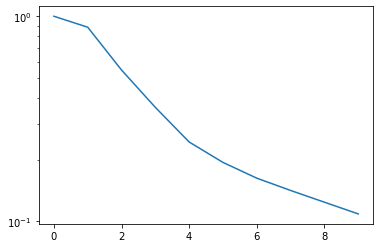

In [8]:
rank = 30
U_als, S_als, VT_als, dist_als = ALS(A_train, rank, 0.1, debug=True)
plt.plot(dist_als)
_ = plt.semilogy()

### c. (3 балла) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также разреженное SVD из scipy (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [12]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)
Ur, Sr, VTr = randomized_svd(A_train, n_components=30)
U, S, VT = svds(A_train, k=30)

print("ALS: ", als_functional(A_train, A_norm, U_als, S_als, VT_als))
print("Randomized SVD: ", als_functional(A_train, A_norm, Ur, np.diag(Sr), VTr))
print("Sparse SVD: ", als_functional(A_train, A_norm, U, np.diag(S), VT))

# Значение функционала примерно одинаково для всех трех функций. 
# Но при этом значение у ALS незначительно выше, чем у остальных функций.
# Если все-таки обращать внимание на такие маленькие различия, то самое маленькое значение функционала
# У разреженного SVD из scipy, чуть больше значение у рандомизированного SVD из sklearn и 
# Самое большое у ALS, но при этом оно больше предшедственника всего в 1.00026209169 раза, так что
# Можно сказать, что ALS выдает очень хорошую точность, сопоставимую с SVD.

ALS:  1640.499851399309
Randomized SVD:  1639.8746740490758
Sparse SVD:  1639.7522515878923


### d. (10 баллов) Построение рекомендаций
Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.

In [74]:
def recommend(VT, known_ratings, n_recs):
    """
        Input
            VT: 2D numpy array
            known_rating: sparse batch_size x n_movies array
            n_recs: requested number of recommendations
            
        Output
            recs: batch_size x n_recs array of movies to recommend, with descending predicted rating
    """
    Q, R = np.linalg.qr(VT.T)
    T = Q.T @ known_ratings.T
    P = Q @ T
    recs = P.T.argsort()[:,-n_recs:][:,::-1]
    return recs
    # raise NotImplementedError()

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [75]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [76]:
def get_hit_rates(VT, A_test, n_recs):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users 
            n_recs: list of ints: number of top recomendations to evaluate hit rate for
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    hit_rates = []
    hit_idx = evaluate_model(VT, A_test, max(n_recs))
    for ind in n_recs:
        hit_rates.append(sum([i < ind for i in hit_idx]) / len(hit_idx))
    return hit_rates
    # raise NotImplementedError()

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [77]:
get_hit_rates(VT, A_test[:1000,:], [10])

[0.1344364012409514]

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

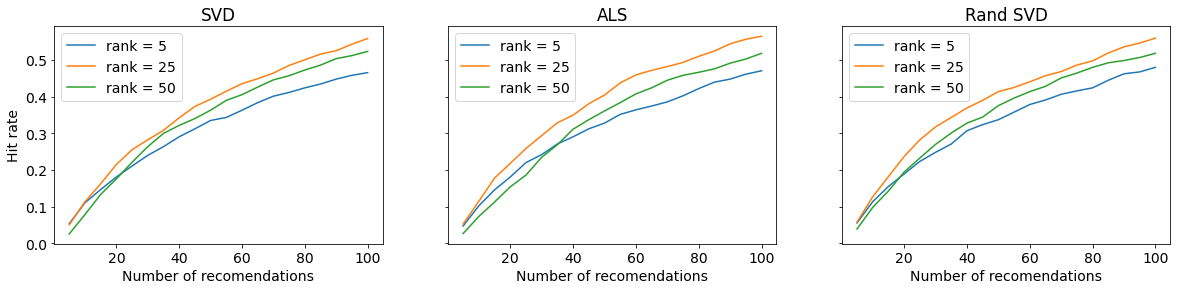

In [80]:
from scipy.sparse.linalg import svds

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, _, VT_als, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

**Ответ:** $\newline$ 1) В случае Sparse SVD видно, что ранги 25 и 50 ведут себя примерно одинаково, но 25 ранг даже немного лучше, и у них хитрейт заметно больше, чем у ранга 5, поэтому оптимальным рангом для данного алгоритма можно назвать ранг 25. $\newline$ 2) В случае ALS видно, что ранг 25 показывает хитрейт заметно больше, чем у 50 и 5 рангов. Поэтому можно назвать 25 ранг оптимальным. $\newline$ 3) В случае рандомизированного SVD 25 ранг снова показывает лучшие результаты, заметно опережая 50 ранг и 5 ранг. $\newline$ Можно отметить, что при этом запуске для всех трех алгоритмов 25 ранг оказался наиболее оптимальным, поэтому во всех трех случаях предпочтительнее использовать 25 ранг.

# Задача 2. Higher-order SVD (25 баллов)

1. (**8 баллов**) Напишите функцию ```tuck2full(G, U, V, W)```, возвращающую полный тензор размера $n_1\times n_2 \times n_3$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U,V$ и $W$ строк меньше, чем столбцов. Это понадобится нам в дальнейшем. В этой задаче не разрешается использовать циклы. Вместо них используйте функцию ```np.einsum```.

In [4]:
def tuck2full(G, U, V, W):
    """
        Input
            G: 3D numpy array - Tucker core of size (r1, r2, r3)
            U: 2D numpy array - the first Tucker factor of size (n1, r1)
            V: 2D numpy array - the second Tucker factor of size (n2, r2)
            W: 2D numpy array - the third Tucker factor of size (n3, r3)

        Output
            A: 3D numpy array of the size (n1, n2, n3)
    """
    res = np.einsum('abg,ia,jb,kg->ijk', G, U, V, W, optimize=True)
    return res

2. (**14 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного трехмерного массива $A\in\mathbb{R}^{n_1\times n_2 \times n_3}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. В этой задаче не разрешается пользоваться циклами. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [77]:
def hosvd(A, eps):
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: 3D numpy array - the Tucker core
            U: 2D numpy array - the first Tucker factor with orthogonal columns
            V: 2D numpy array - the second Tucker factor with orthogonal columns
            W: 2D numpy array - the third Tucker factor with orthogonal columns
    """
    m = A.shape[0]
    n = A.shape[1]
    l = A.shape[2]
    A_1 = np.reshape(A, (m, n * l), order='f')
    A_2 = np.reshape(np.transpose(A, (1, 0, 2)), (n, m * l), order='f')
    A_3 = np.reshape(np.transpose(A, (2, 0, 1)), (l, n * m), order='f')
    comp = 0
    U1, _, _ = randomized_svd(A_1, n_components=min(A_1.shape[0], A_1.shape[1]))
    U_1 = U1[:,:comp]
    norm1 = np.linalg.norm(A_1)
    while (np.linalg.norm(A_1 - U_1 @ U_1.T @ A_1) * (3 ** 0.5) >= eps * norm1):
        U_1 = U1[:,:comp]
        comp += 1
    comp = 0
    U2, _, _ = randomized_svd(A_2, n_components=min(A_2.shape[0], A_2.shape[1]))
    U_2 = U2[:,:comp]
    norm2 = np.linalg.norm(A_2)
    while (np.linalg.norm(A_2 - U_2 @ U_2.T @ A_2) * (3 ** 0.5) >= eps * norm2):
        U_2 = U2[:,:comp]
        comp += 1
    comp = 0
    U3, _, _ = randomized_svd(A_3, n_components=min(A_3.shape[0], A_3.shape[1]))
    U_3 = U3[:,:comp]
    norm3 = np.linalg.norm(A_3)
    while (np.linalg.norm(A_3 - U_3 @ U_3.T @ A_3) * (3 ** 0.5) >= eps * norm3):
        U_3 = U3[:,:comp]
        comp += 1
    G = tuck2full(A, U_1.T, U_2.T, U_3.T)
    return G, U_1, U_2, U_3

3. (**3 балла**) Примените функцию ```hosvd``` к тензору размера $100 \times 200 \times 300$ с элементами
$$
    a_{ijk} = \frac{1}{i + j + k + 1}, \quad i,j,k=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [78]:
tens = np.zeros((100, 200, 300))
for i in range(100):
    for j in range(200):
        for k in range(300):
            tens[i, j, k] = 1 / (i + j + k + 1)

G, U, V, W = hosvd(tens, 0.000001)
print("R1 = ", U.shape[1])
print("R2 = ", V.shape[1])
print("R3 = ", W.shape[1])
np.linalg.norm(np.reshape(tens - tuck2full(G, U, V, W), (1, 100 * 200 * 300))) / np.linalg.norm(np.reshape(tens, (1, 100 * 200 * 300)))


R1 =  10
R2 =  11
R3 =  11


4.84346431528219e-07